In [35]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from ekf_vindy.plotting import plotter
from ekf_vindy.utils import add_noise_with_snr
from ekf_vindy.filters.config import DynamicsConfig
from ekf_vindy.filters.ekf import EKF
from scipy.integrate import odeint

seed = 29
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EKF-SINDy with Duffing oscillator

We examine a simulation with a Duffing oscillator, and we want to inform the filter about energy conservation. Some possible examples

- Start from a wrong model (obtained by SINDy), where there's a damping term. Such a damping term must fade during online inference. However, we should be able to see the term disappear faster in the physics-informed EKF case.
- The other way around, learn a system where energy is conserved, and energy gradually is lost via a damping term that becomes active after a certain point during the online phase. Again, we should see the EKF be faster in adapting to the environment given the constraint. 

Not really the case... because you're inferring two different things that are odds with each other. This is evident in the undamped oscillator, if you start with a damped model, the energy conservation (assuming we see a trajectory where energy indeed is conserved) actually makes things worse...

## Duffing oscillator

The undamped Duffing oscillator is the following

$$
\ddot{x}+\alpha x + \beta x^3 = 0
$$

Energy is conserved (a physical constraint in an isolated system). We will also considered the damped oscillator.

$$
\ddot{x}+\delta \dot{x}+\alpha x+ \beta x^3 = 0, \,\,\delta > 0
$$

We consider the first-order version of the damped oscillator

$$
\begin{aligned}
\dot{x}_0 &= x_1,\\
\dot{x}_1 &= - \alpha x_0-  \beta x_0^3 - \delta x_1
\end{aligned}
$$

In [2]:
def duffing_oscillator(x, t, params, t_conservation):
    """
    Duffing oscillator ODE
    """
    if t >= t_conservation:
        delta = 0.0
    else:
        delta = params['delta']
    
    dxdt = x[1]
    dvdt = - params['alpha'] * x[0] - params['beta'] * x[0] ** 3 - delta * x[1]
    
    return [dxdt, dvdt]

The total energy of this system is given by the Hamiltonian (potential and kinetic energy). 

$$
H(x(t), \dot{x}(t)) = \frac{1}{2}\dot{x}^2(t) +\frac{1}{2}\alpha x^2(t) +\frac{1}{4}\beta x^4(t)
$$

So want we want to enforce is that the energy at the initial state (assuming there's no loss), is equal to the energy in successive states. So

$$
g(x(t), \dot{x}(t)) = H(x(t), \dot{x}(t)) - H(x(0), \dot{x}(0)) = 0
$$

Since we will put this into the filter, as a pseudo-observation, we must linearize the constraint $g(x(t), \dot{x}(t))$, so we need its Jacobian. In this case, we can easily derive in closed-form. Note that we are cheating, since we assume to know the true form of the Hamiltonian.

In [77]:
def energy(x):
    """
    Hamiltonian (total energy) of the Duffing oscillator
    """
    alpha = 1   # Linear stiffness
    beta = 1     # Nonlinear stiffness
    
    kinetic = 0.5 * x[1]**2
    potential = 0.5 * alpha * x[0]**2 + 0.25 * beta * x[0]**4
    
    return kinetic + potential

def jacobian_constraint(x, extra_terms):
    """
    Jacobian of the energy constraint
    The extra terms are for the augmented state (they will be zeros).
    """
    alpha = 1   # Linear stiffness
    beta = 1     # Nonlinear stiffness
    
    dH_dx = np.array([alpha * x[0] + beta * x[0]**3, x[1]])
    dH_dx = dH_dx.reshape(1, -1)
    dH_dx = np.hstack((dH_dx, np.zeros((1, extra_terms))))

    return dH_dx

Generate trajectories in the undamped case and train SINDy...

(x0)' = 0.985 x1
(x1)' = -0.940 x0 + -0.491 x1 + -1.037 x0^3


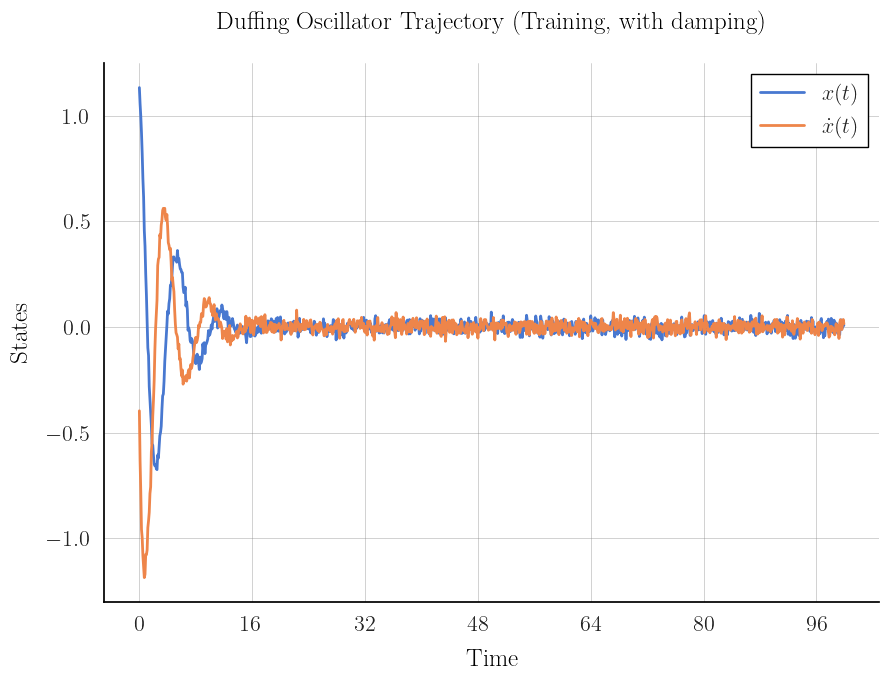

In [124]:
params = {
    'alpha': 1,   # Linear stiffness
    'beta': 1,     # Nonlinear stiffness
    'delta': 0.5,  # Damping coefficient
}

# Generate training data (around [1.5, 0] initial condition)
t_conservation = 100.0 # energy is depleted by then

n_train = 20
std = 0.5
mean_ic = np.array([1.5, 0.0])
x_0 = np.random.randn(n_train, 2) * std + mean_ic
time_instances = np.arange(0, 100, 0.1)
x_train = []


for i in range(n_train):
    sol = odeint(duffing_oscillator, x_0[i, :], time_instances, args=(params, t_conservation))
    x_train.append(sol)

x_train = np.array(x_train)
x_train = [noisy_traj for noisy_traj in add_noise_with_snr(x_train, snr=20)]

model = ps.SINDy(feature_names=['x0', 'x1'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))

model.fit(x_train, t=0.1, multiple_trajectories=True)
model.print()

# plot one trajectory from x_train
fig, ax = plotter.plot_trajectory(x_train[0], time_instances, title='Duffing Oscillator Trajectory (Training, with damping)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"])
plt.show()

What if system suddenly becomes conservative? So the damping term $\delta$ goes to zero abruptly. We define the constraint object and set a very small noise (can you do the update at the same time?)

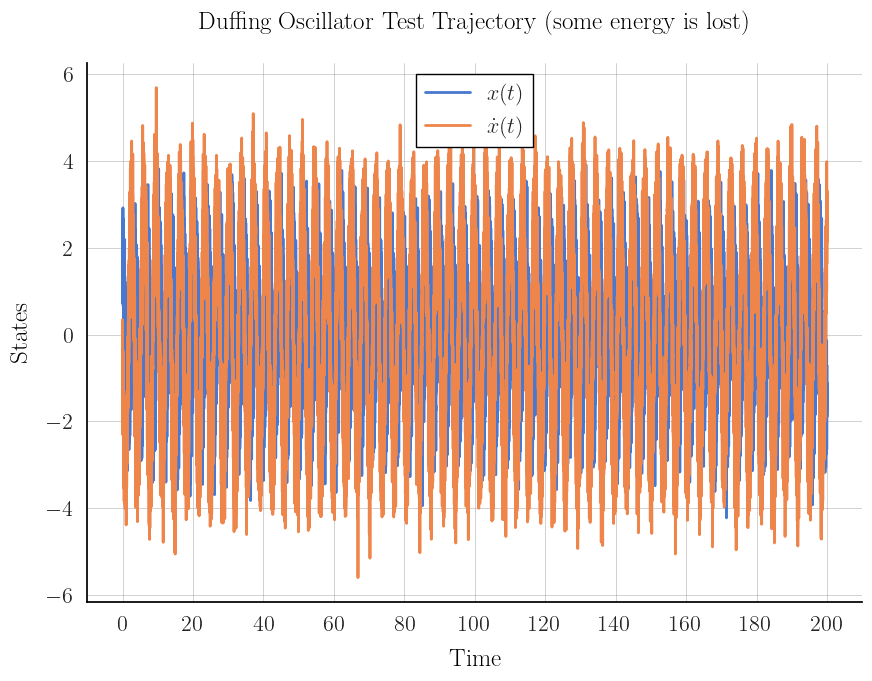

In [151]:
from ekf_vindy.filters.constraints import Constraint

t_conservation = 0.0
time_instances = np.arange(0, 200, 0.01)
x_0_test = np.random.randn(1, 2) * std + mean_ic
x_test = odeint(duffing_oscillator, x_0_test[0, :], time_instances, args=(params, t_conservation))
x_test = add_noise_with_snr(x_test, snr=8)

fig, ax = plotter.plot_trajectory(x_test, time_instances, x_tick_skip=20, title='Duffing Oscillator Test Trajectory (some energy is lost)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"])
plt.show()

And now we setup the Kalman filter

library_terms: ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']


Processing: 100%|██████████| 19999/19999 [00:06<00:00, 3182.13it/s]


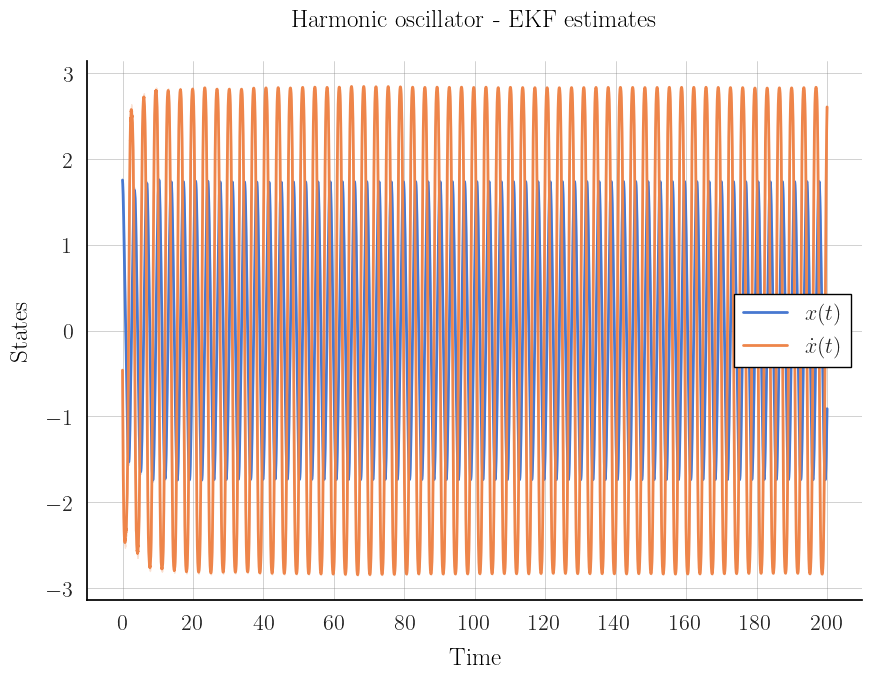

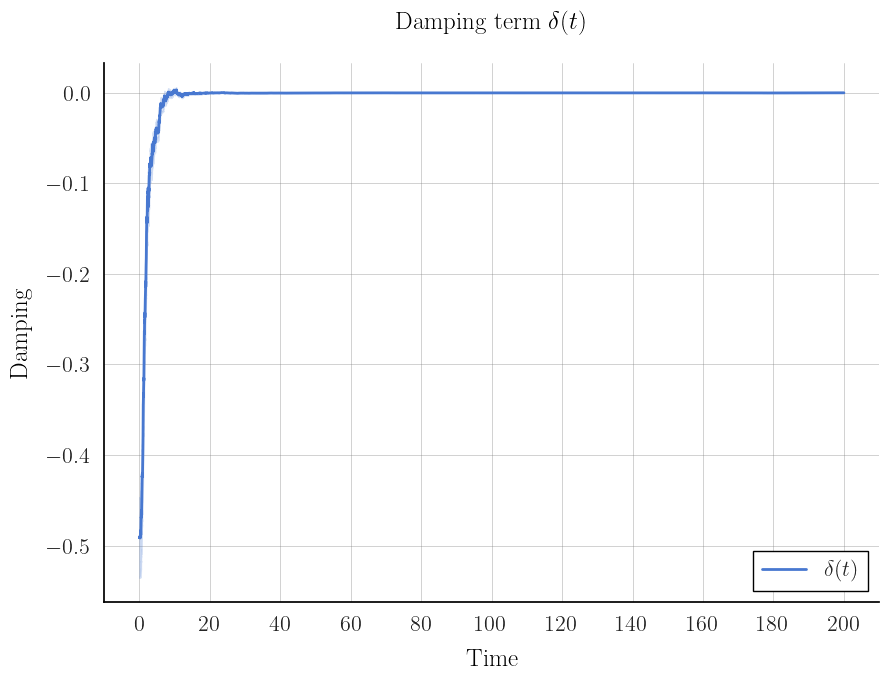

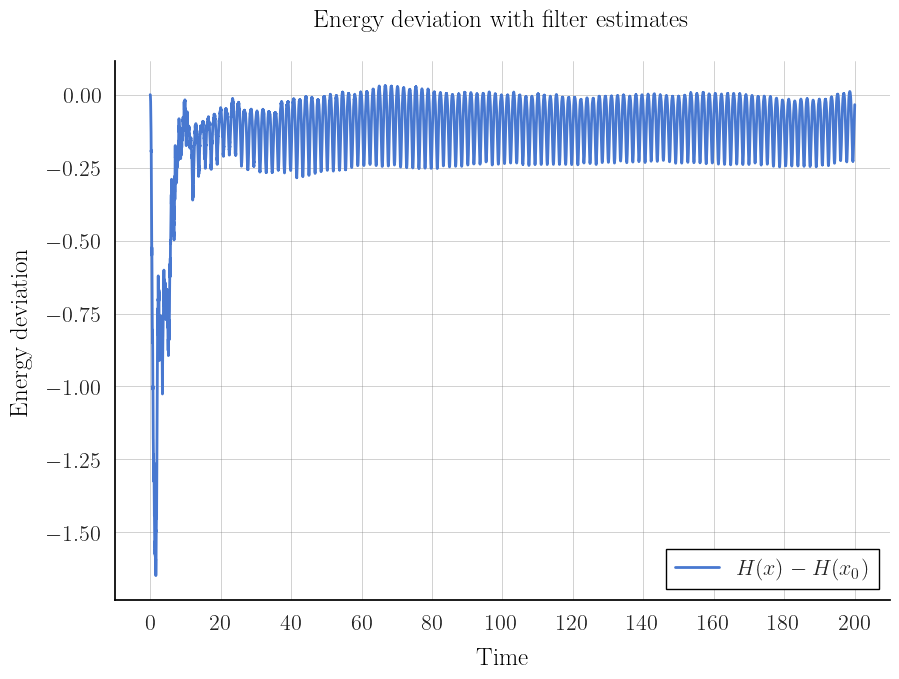

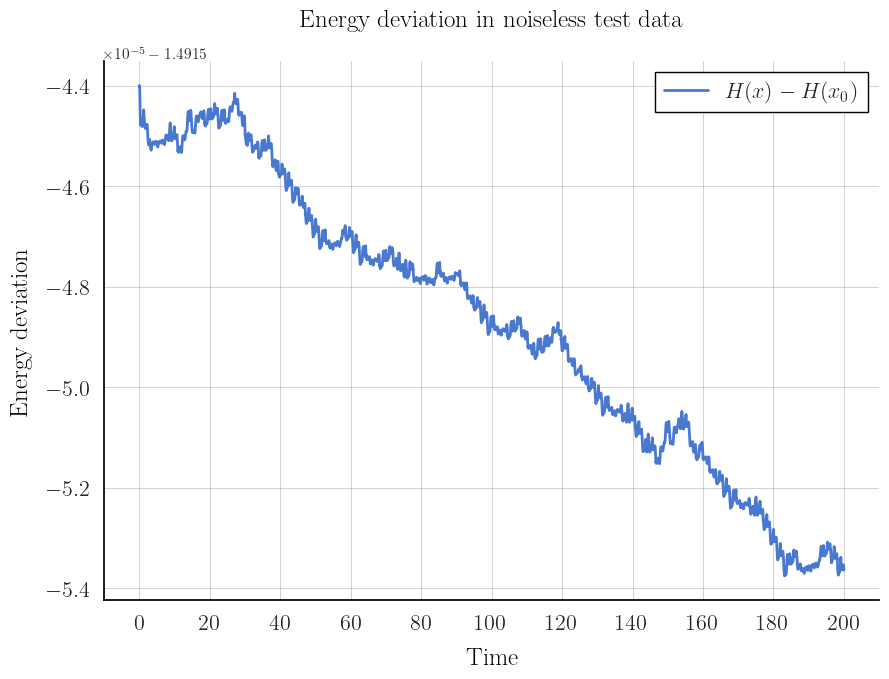

In [152]:
# EKF configuration
p0 = np.diag([1e-8, 1e-8, 5e-4, 5e-4, 5e-4, 5e-4]) # initial state covariance
q = np.diag([1e-8, 1e-8, 1e-10, 1e-10, 1e-10, 1e-10]) # process noise covariance
r = np.diag([8e-2, 8e-2]) 

library_terms = model.get_feature_names()
coeffs = model.coefficients()
variables = model.feature_names

print(f'library_terms: {library_terms}')
tracked_terms = [[2],
                 [1, 2, 6]]

x0 = x_0_test[0, :]
config = DynamicsConfig(variables, library_terms, tracked_terms, coeffs, q, r)
filter = EKF(x0, p0, config=config, integration_rule='RK4')

dts = np.diff(time_instances)
observations = x_test[1:, :]
filter.run_filter(dts, observations)

filter_estimates = filter.states.xcal_states[:, 0:2]
sdevs = filter.states.sdev_states[:, 0:2]

fig, x = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=20, title='Harmonic oscillator - EKF estimates', xlabel='Time', ylabel='States', state_names=["$x(t)$", "$\dot{x}(t)$"])
plt.show()

damping_term = filter.states.xcal_states[:, 4:5]
damping_sdev = filter.states.sdev_states[:, 4:5]

fig, x = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=20, title="Damping term $\delta (t)$", state_names=["$\delta (t)$"], xlabel='Time', ylabel='Damping')
plt.show()

# compute energy
def energy_constraint(x, x0):
     return np.array([energy(x) - energy(x0)])
constraint_with_x0 = lambda x: energy_constraint(x, x0)

# is energy conserved?
energy_diff = [constraint_with_x0(xi) for xi in filter_estimates]
energy_diff = np.array(energy_diff)
fig, ax = plotter.plot_trajectory(energy_diff, time_instances, x_tick_skip=20, title='Energy deviation with filter estimates', xlabel='Time', ylabel='Energy deviation', state_names=["$H(x) - H(x_0)$"])
plt.show()

# now in the actual non-noisy training data
x_0_test = np.random.randn(1, 2) * std + mean_ic
x_test = odeint(duffing_oscillator, x_0_test[0, :], time_instances, args=(params, t_conservation))
energy_diff = [constraint_with_x0(xi) for xi in x_test]
energy_diff = np.array(energy_diff)
fig, ax = plotter.plot_trajectory(energy_diff, time_instances, x_tick_skip=20, title='Energy deviation in noiseless test data', xlabel='Time', ylabel='Energy deviation', state_names=["$H(x) - H(x_0)$"])
plt.show()



Now let's consider the energy conservation constraint (from $t=0$)

Processing: 100%|██████████| 19999/19999 [00:09<00:00, 2023.75it/s]


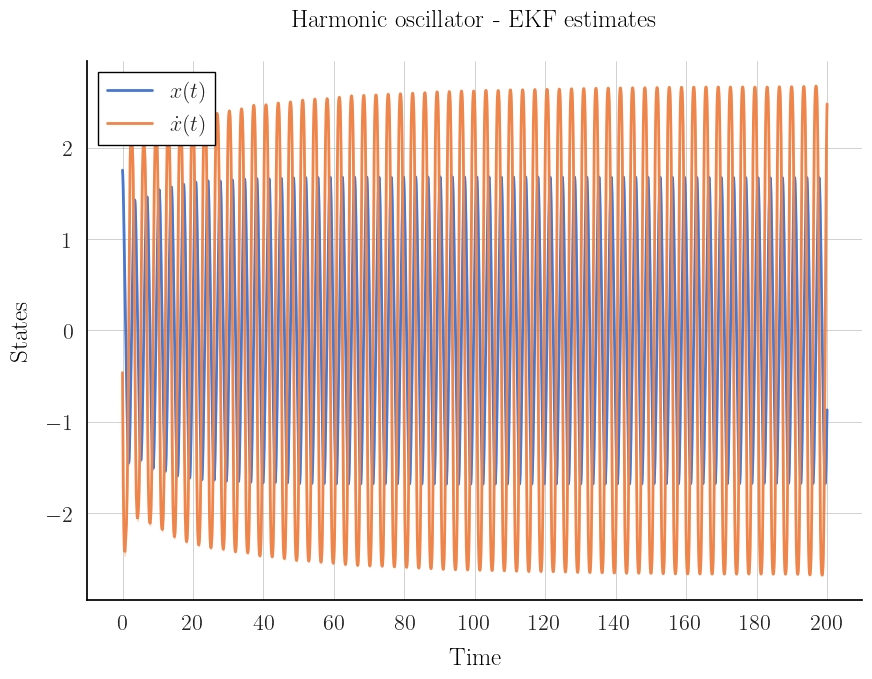

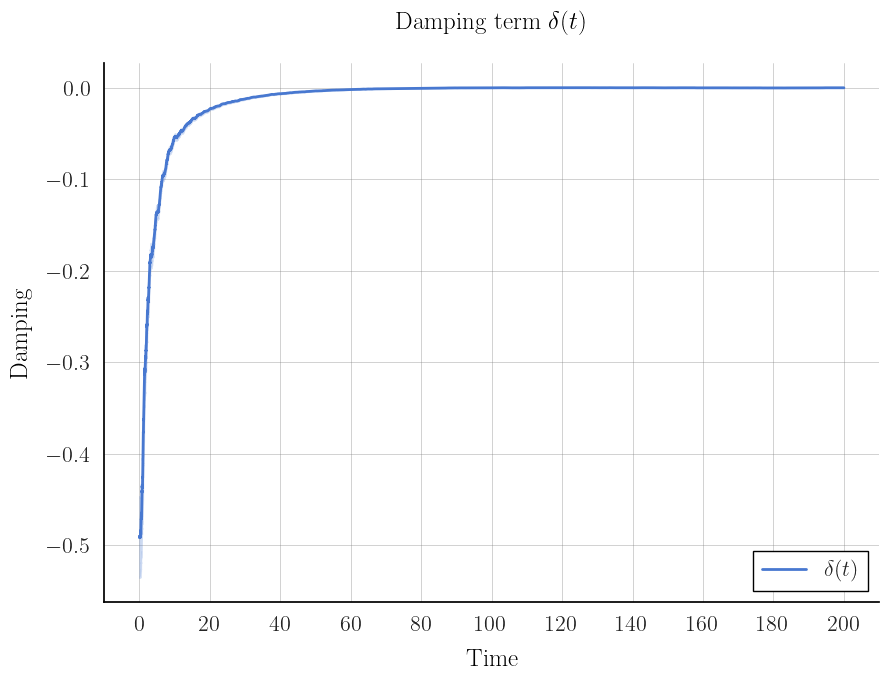

In [156]:
from ekf_vindy.plotting import plotter
from ekf_vindy.filters.ekf import EKF


# we are cheating a bit here by using the true energy function
def energy_constraint(x, x0):
     return np.array([energy(x) - energy(x0)])

jacobian_with_terms = lambda x: jacobian_constraint(x, extra_terms=4)
constraint_with_x0 = lambda x: energy_constraint(x, x0)

constr_cov = np.diag([3e-1])
constraint = Constraint(constraint_with_x0, jacobian_with_terms, constr_cov)

filter = EKF(x0, p0, config=config, integration_rule='RK4')
filter.run_filter(dts, observations, constraint)

filter_estimates = filter.states.xcal_states[:, 0:2]
sdevs = filter.states.sdev_states[:, 0:2]
fig, x = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=20, title='Harmonic oscillator - EKF estimates', xlabel='Time', ylabel='States', state_names=["$x(t)$", "$\dot{x}(t)$"])
plt.show()

damping_term = filter.states.xcal_states[:, 4:5]
damping_sdev = filter.states.sdev_states[:, 4:5]
fig, x = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=20, title="Damping term $\delta (t)$", state_names=["$\delta (t)$"], xlabel='Time', ylabel='Damping')
plt.show()
